### Imports

In [94]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# Preprocessing and data splits

Filtered dataset size: 11867
Training examples: 1000
Validation examples: 1000
Test examples: 1000


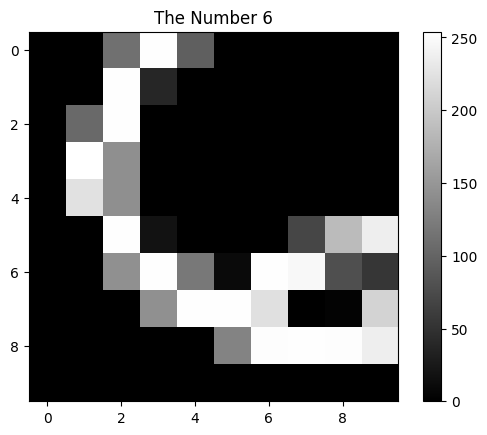

(array([6, 9], dtype=uint8), array([1527, 1473]))


In [78]:


data = loadmat('data/MNISTmini.mat')
# print(data.keys())  # Shows variables in the file
# dataFrame  = pd.DataFrame(data)

# colList = []
# for i in range(len(data['train_fea1'][0])):
#     colList.append(f"col{i+1}")

# indexTrain = np.where(data['train_gnd1'] == 6)[0].tolist() + np.where(data['train_gnd1'] == 9)[0].tolist()
# print(len(indexTrain))
# dfTrain = pd.DataFrame(data['train_fea1'][indexTrain], columns=colList)
# dfTrain['y'] = data['train_gnd1'][indexTrain]
# dfTrain['y'] = dfTrain['y'].replace({6: 0, 9: 1})
# dfTrain = dfTrain.reset_index(drop=True)

# # Train and validation sets
# x_train, x_val, y_train, y_val = train_test_split(dfTrain.drop(columns=['y']).reset_index(drop=True), dfTrain['y'], test_size=0.2, random_state=42)
# indexTest = np.where(data['test_gnd1'] == 6)[0].tolist() + np.where(data['test_gnd1'] == 9)[0].tolist()
# dfTest = pd.DataFrame(data['test_fea1'][indexTest], columns=colList)
# dfTest['y'] = data['test_gnd1'][indexTest]
# dfTest['y'] = dfTest['y'].replace({6: 0, 9: 1})
# # Test sets
# x_test = dfTest.drop(columns=['y'])
# y_test = dfTest["y"]
 

# img = x_train.iloc[0].to_numpy()
# # Tranpose because the image is rotated
# img = np.transpose(img.reshape(10,10))
# # use grayscale
# plt.title(f"The Number {6 if y_train.iloc[0] == 0 else 9}")
# plt.imshow(img, cmap='gray')  
# plt.colorbar()                
# plt.show()


#Changing to only index 1 to 3000

X = data['train_fea1']
y = data['train_gnd1'].ravel()

#Filter for 6 and 9

mask = (y== 6) | (y == 9)
x_filt = X[mask]
y_filt = y[mask]

print("Filtered dataset size:", x_filt.shape[0])
np.random.seed(42)   # for reproducibility
indices = np.random.choice(len(x_filt), 3000, replace=False)

#Get the first 3000 images

X_3000 = x_filt[indices]
y_3000 = y_filt[indices]

#Separate into training, validation, and testing set

x_train = X_3000[:1000]
y_train = y_3000[:1000]

x_val = X_3000[1000:2000]
y_val = y_3000[1000:2000]

x_test = X_3000[2000:3000]
y_test = y_3000[2000:3000]

#Get labels 6 = 0, 9 = 1
y_train = np.where(y_train == 6, 0, 1)
y_val = np.where(y_val == 6, 0, 1)
y_test = np.where(y_test == 6, 0, 1)

#Convert to data frames
colList = [f"col{i+1}" for i in range(x_train.shape[1])]

dfTrain = pd.DataFrame(x_train, columns=colList)
dfTrain['y'] = y_train

dfVal = pd.DataFrame(x_val, columns=colList)
dfVal['y'] = y_val

dfTest = pd.DataFrame(x_test, columns=colList)
dfTest['y'] = y_test


print("Training examples:", len(x_train))
print("Validation examples:", len(x_val))
print("Test examples:", len(x_test))

idx = 0
img = dfTrain.drop(columns=['y']).iloc[idx].to_numpy()
img = np.transpose(img.reshape(10,10))
label = dfTrain['y'].iloc[idx]
digit = 6 if label == 0 else 9

plt.title(f"The Number {digit}")
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.show()

import numpy as np
print(np.unique(y_3000, return_counts=True))


# Training

## Simple logistical Regresssion with l2 regularization

In [101]:
logisticFit = LogisticRegression(solver="liblinear", penalty="l2", random_state=1)
logisticFit.fit(x_train, y_train)

pred_train = logisticFit.predict(x_train)
pred_val = logisticFit.predict(x_val)

pred_train_score = accuracy_score(y_train, pred_train)
pred_val_score = accuracy_score(y_val, pred_val)

print(f"Train Accuracy: {pred_train_score}")
print(f"Validation Accuracy: {pred_val_score}")


Train Accuracy: 1.0
Validation Accuracy: 0.995


### The validation accuracy is pretty high so the test accuracy will be too, so we will add the validation set to the model.

In [102]:
X = dfTrain.drop(columns  =['y'])
Y = dfTrain['y']
logisticFit.fit(X,Y)
# now check test accuracy
pred_test = logisticFit.predict(x_test)
pred_test_score = accuracy_score(y_test, pred_test)
print(f"Test Accuracy: {pred_test_score}")


Test Accuracy: 0.996


c:\Users\samy_\CSE176\CSE176MLProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### The testing accuracy of is very close to 1 only off by about .004, so this classifier is pretty good.

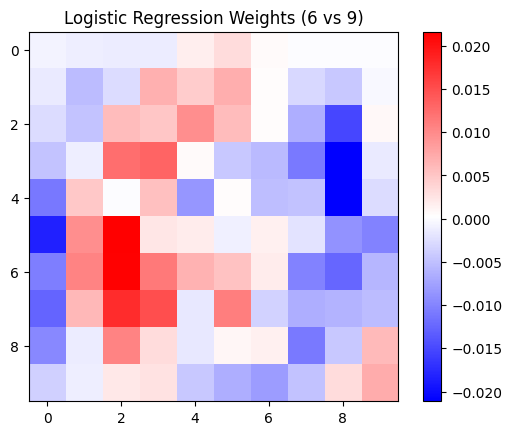

In [103]:
weights = logisticFit.coef_.reshape(10, 10)

plt.imshow(weights, cmap="bwr")  # blue = negative, red = positive
plt.colorbar()
plt.title("Logistic Regression Weights (6 vs 9)")
plt.show()

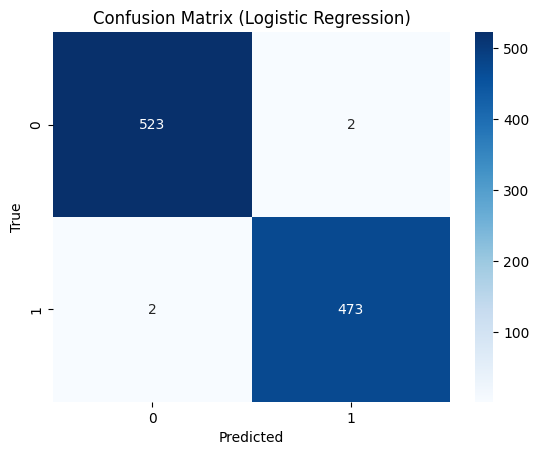

In [84]:
cm = confusion_matrix(y_test, pred_test)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()


## Logistical Regression with CV 

In [85]:
logSpace = np.logspace(-5,5, 100)
logisticCV = LogisticRegressionCV(Cs = logSpace, cv = 10, solver="liblinear", penalty="l2", random_state=1)
logisticCV.fit(x_train, y_train)


,Cs,array([1.0000...00000000e+05])
,fit_intercept,True
,cv,10
,dual,False
,penalty,'l2'
,scoring,None
,solver,'liblinear'
,tol,0.0001
,max_iter,100
,class_weight,None
,n_jobs,None


In [87]:
pred_train = logisticCV.predict(x_train)
pred_val = logisticCV.predict(x_val)

pred_train_score = accuracy_score(y_train, pred_train)
pred_val_score = accuracy_score(y_val, pred_val)
print(f"CV logistical Train score: {pred_train_score}")
print(f"CV logistical Validation score: {pred_val_score}")
print(f"The best hyper-parameter: {logisticCV.C_[0]}")


CV logistical Train score: 1.0
CV logistical Validation score: 0.996
The best hyper-parameter: 3.199267137797385e-05


### The validation accuracy for this model is very high so we can juse refit the model with the training and validation set so we can have get the test accuracy.

In [88]:
# refit model
logisticCV.fit(X, Y)

,Cs,array([1.0000...00000000e+05])
,fit_intercept,True
,cv,10
,dual,False
,penalty,'l2'
,scoring,None
,solver,'liblinear'
,tol,0.0001
,max_iter,100
,class_weight,None
,n_jobs,None


In [100]:
pred_train = logisticCV.predict(x_train)
pred_val = logisticCV.predict(x_val)

pred_train_score = accuracy_score(y_train, pred_train)
pred_val_score = accuracy_score(y_val, pred_val)
print(f"CV logistical Train score: {pred_train_score}")
print(f"CV logistical Validation score: {pred_val_score}")

pred_test = logisticCV.predict(x_test)
pred_test_score = accuracy_score(y_test, pred_test)
print(f"CV logistical Test score: {pred_test_score}")
print(f"The best hyper-parameter: {logisticCV.C_[0]}")

CV logistical Train score: 1.0
CV logistical Validation score: 0.996
CV logistical Test score: 0.997
The best hyper-parameter: 3.199267137797385e-05


c:\Users\samy_\CSE176\CSE176MLProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegressionCV was fitted with feature names
  warnings.warn(
c:\Users\samy_\CSE176\CSE176MLProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegressionCV was fitted with feature names
  warnings.warn(
c:\Users\samy_\CSE176\CSE176MLProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegressionCV was fitted with feature names
  warnings.warn(


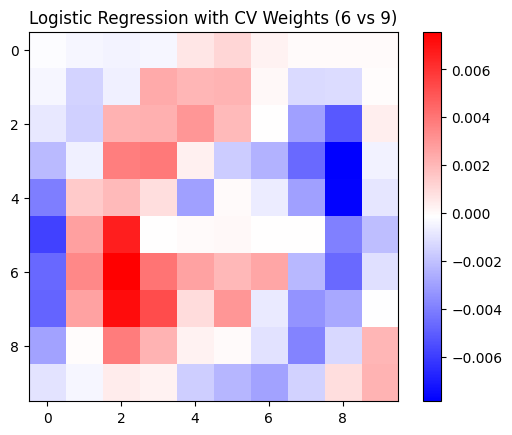

In [91]:
weights = logisticCV.coef_.reshape(10, 10)

plt.imshow(weights, cmap="bwr")  # blue = negative, red = positive
plt.colorbar()
plt.title("Logistic Regression with CV Weights (6 vs 9)")
plt.show()

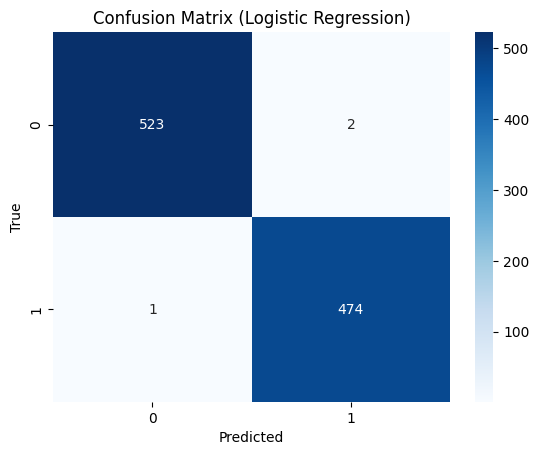

In [92]:
cm = confusion_matrix(y_test, pred_test)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

## Random Forests

In [95]:
X_train = dfTrain.drop(columns='y').to_numpy()
y_train = dfTrain['y'].to_numpy()

X_val = dfVal.drop(columns='y').to_numpy()
y_val = dfVal['y'].to_numpy()

X_test = dfTest.drop(columns='y').to_numpy()
y_test = dfTest['y'].to_numpy()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 50}
Best cross-validation accuracy: 0.9970000000000001


The best parameters we obtained are: Criterion = gini, Max_depth = None, Number of estimators = 50. The best Cross-validation accuracy was 0.9970000000000001, so approximately 99.7%

In [ ]:
#Evaluate on the validation set

best_rf = grid_search.best_estimator_
val_preds = best_rf.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)

print("Validation Acc:", val_accuracy)

Validation Acc:  0.994


On the validation set the model had a 99.4% accuracy, which is very close to the cross validation accuracy. The numbers are close which means the model is not overfitting much.

In [97]:
test_preds = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)
print("Test Acc:", test_accuracy)

Test Acc: 0.997


The test accuracy is of 99.7%, which is very high. Compared to the other sets this means that our model generalizes very well and is able to distinguish between 6 and 9.

### Below we can see the confusion matrix, and the feature importance of the random forest.

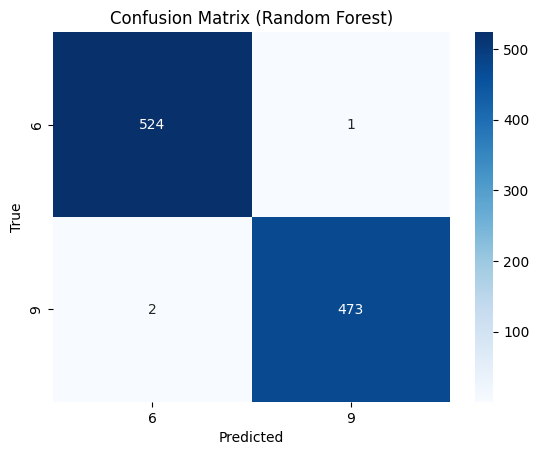

In [99]:
cm = confusion_matrix(y_test, test_preds)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[6,9], yticklabels=[6,9])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Random Forest)")
plt.show()

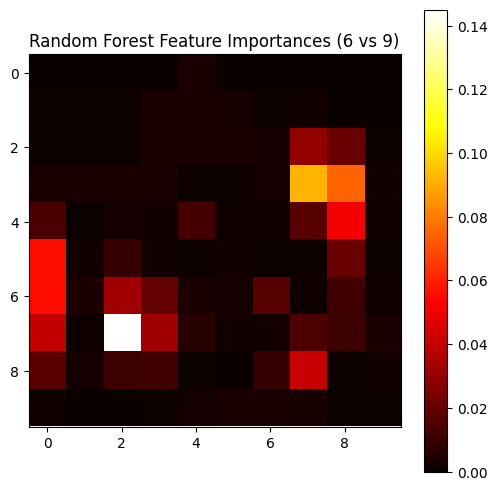

In [104]:
importances = best_rf.feature_importances_
plt.figure(figsize=(6,6))
plt.imshow(importances.reshape(10,10), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Random Forest Feature Importances (6 vs 9)")
plt.show()
